## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import random
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.data.dataset import SeattleRainfall
from ts.utility import Utility
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso
from ts.plot import Plot

## Load Dataset

In [2]:
rainfall_df = SeattleRainfall.loadData('/Users/ahmed/Downloads/Datasets/SeattleRainfall')
rainfall_df

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25546,2017-12-10,0.00,49,34,False
25547,2017-12-11,0.00,49,29,False
25548,2017-12-12,0.00,46,32,False
25549,2017-12-13,0.00,48,34,False


### Get Rainfall Series

In [3]:
rainfall_series = rainfall_df['PRCP'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}, '
    + f'Contains NaN: {np.isnan(rainfall_series).any()}')

Rainfall data: datatype: float64, shape: (25551,), Contains NaN: True


### Fill Missing Data

In [4]:
nan_indices = list(np.where(np.isnan(rainfall_series))[0])
left_length = 5
right_length = 5

for idx in list(nan_indices):
    values = rainfall_series[
        max(idx - left_length, 0): min(idx + right_length + 1, n)
    ]
    
    values = values[np.logical_not(np.isnan(values))]
    rainfall_series[idx] = values.mean()

print(f'Contains NaN: {np.isnan(rainfall_series).any()}')

Contains NaN: False


## Train-Test Split

In [5]:
train_frac = 0.90
num_train = int(n * train_frac)

print(f'Length of training series: {num_train}, '
     + f'Length of test series: {n - num_train}')

Length of training series: 22995, Length of test series: 2556


### Plot Entire Data

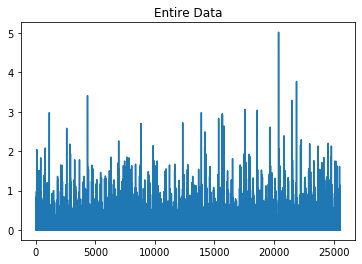

In [6]:
plt.plot(rainfall_series)
plt.title('Entire Data')
plt.show()

### All Data Histogram

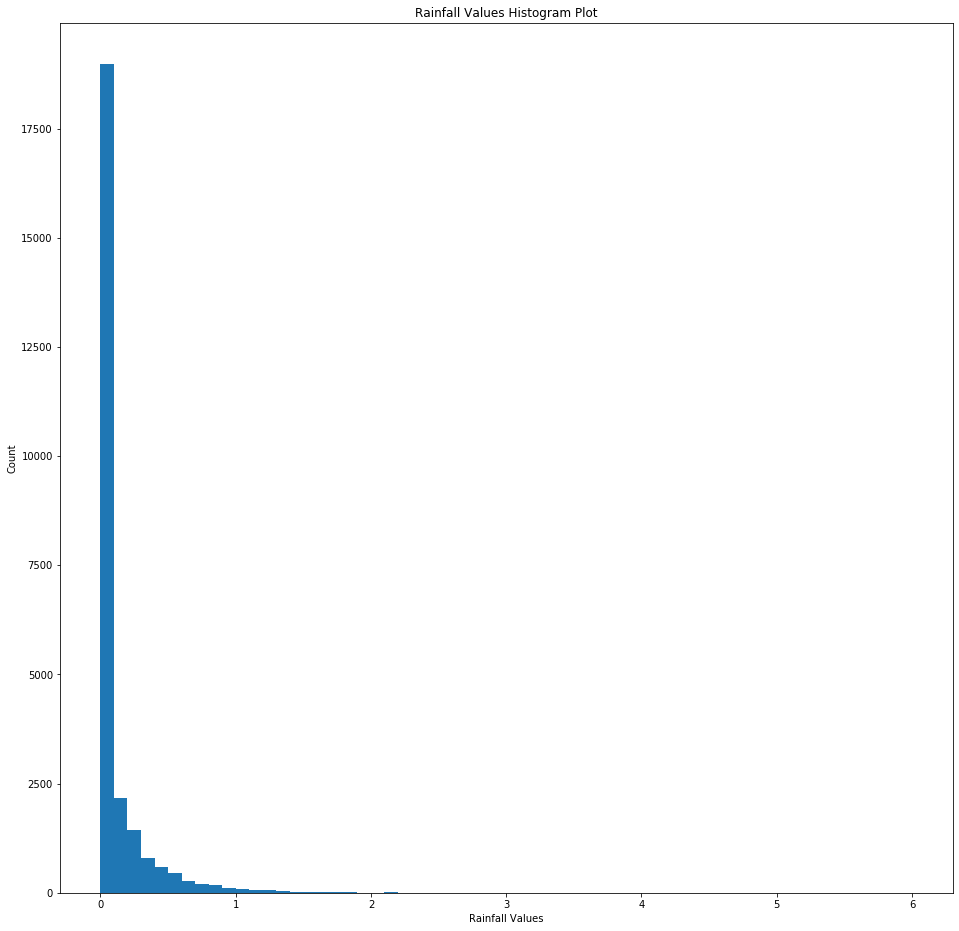

In [7]:
bin_width = 0.1
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

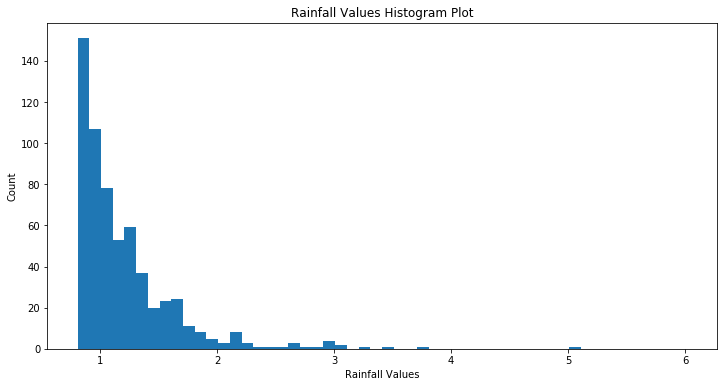

In [8]:
lower_bound = 0.8

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 0.1
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

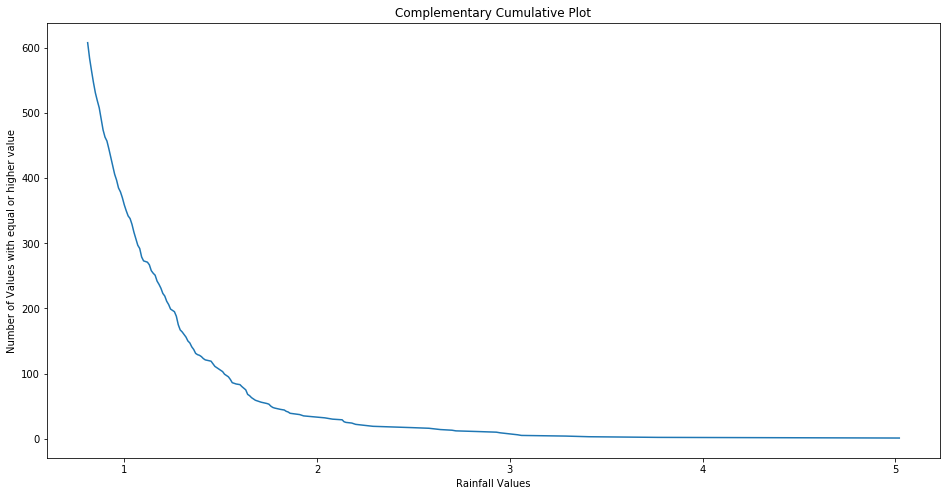

In [9]:
lower_bound = 0.8

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [10]:
threshold = 0.8 # Rainfall in inches

exceed_series = []

for i in range(num_train):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (524,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.12482373388970158 
Scale Parameter: 0.354797270254191 
Log Likelihood: -46.434265963335065


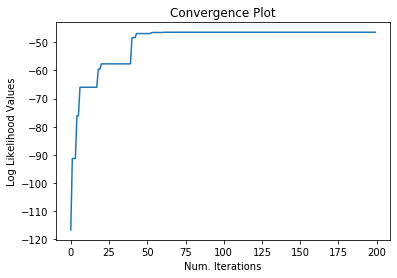

In [11]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 250),
    numIterations=200
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [12]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

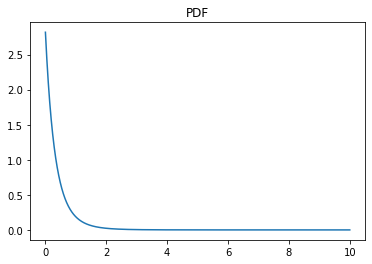

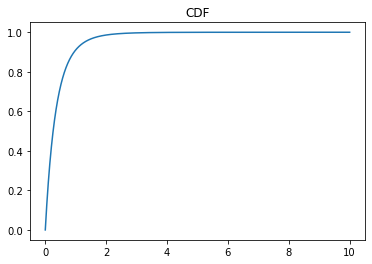

In [13]:
x = np.linspace(0, 10, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [14]:
lag = 30

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.02, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [15]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (524, 30)
Output Data: datatype: float64, shape: (524, 1)


In [16]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 , 0.  , 0.  , 0.  ,
        0.  , 0.22, 0.03, 0.21, 0.03, 0.  , 0.2 , 0.14, 0.  , 0.  , 0.06,
        0.56, 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.35],
       [0.  , 0.  , 0.  , 0.22, 0.03, 0.21, 0.03, 0.  , 0.2 , 0.14, 0.  ,
        0.  , 0.06, 0.56, 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.35, 0.84,
        0.13, 0.01, 0.  , 0.74, 0.46, 0.11, 0.  , 0.05],
       [0.74, 0.46, 0.11, 0.  , 0.05, 0.98, 0.09, 0.  , 0.  , 0.  , 0.19,
        0.  , 0.  , 0.  , 0.  , 0.06, 0.16, 0.11, 0.  , 0.  , 0.08, 0.06,
        0.02, 0.  , 0.  , 0.  , 0.01, 0.13, 0.  , 0.06],
       [0.  , 0.05, 0.  , 0.16, 0.01, 0.08, 0.59, 0.  , 0.56, 0.27, 0.  ,
        0.02, 0.  , 0.26, 0.  , 0.39, 0.14, 0.03, 0.  , 0.29, 0.  , 0.01,
        0.1 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.  , 0.16, 0.01, 0.08, 0.59, 0.  , 0.56, 0.27, 0.  , 0.02,
        0.  , 0.26, 0.  , 0.39, 0.14, 0.03, 0.  , 0.29, 0.  , 0.01, 0.1 ,
        0.  , 

### Train the Model

Epoch 1/100
17/17 [==============================] - 0s 986us/step - loss: 0.0822
Epoch 2/100
17/17 [==============================] - 0s 842us/step - loss: 0.0817
Epoch 3/100
17/17 [==============================] - 0s 758us/step - loss: 0.0811
Epoch 4/100
17/17 [==============================] - 0s 762us/step - loss: 0.0808
Epoch 5/100
17/17 [==============================] - 0s 745us/step - loss: 0.0803
Epoch 6/100
17/17 [==============================] - 0s 728us/step - loss: 0.0810
Epoch 7/100
17/17 [==============================] - 0s 735us/step - loss: 0.0799
Epoch 8/100
17/17 [==============================] - 0s 730us/step - loss: 0.0775
Epoch 9/100
17/17 [==============================] - 0s 759us/step - loss: 0.0728
Epoch 10/100
17/17 [==============================] - 0s 977us/step - loss: 0.0695
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0680
Epoch 12/100
17/17 [==============================] - 0s 902us/step - loss: 0.0628
Epoch 13/100
17

17/17 [==============================] - 0s 1ms/step - loss: 0.0046


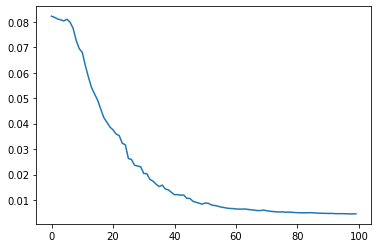

In [17]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [18]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (84, 30)
Output Test Data: datatype: float64, shape: (84, 1)

Test Loss (CDF): 0.16750089824199677
Test Loss (Actual): 0.3223267197608948


## Part 2: Extreme Value Detection (Classification) Algorithm

In [19]:
class MlpEnsemble:
    
    def get_model(self, lag):
        
        model = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        
        model.build(input_shape=(None, lag))
        model.compile(
            optimizer=Adam(
                ExponentialDecay(
                    1e-3, 50, 0.9
                )
            ),
            loss=BinaryCrossentropy(from_logits=True)
        )
        
        return model
    
    def __init__(self, lag, num_models=10, neg_data_ratio=1.0):
        
        self.models = [self.get_model(lag) for _ in range(num_models)]
        self.neg_data_ratio = neg_data_ratio
        
    def train(self, input_data, output_data, each_model_epochs):
        
        pos_data = []
        neg_data = []
        
        for i in range(input_data.shape[0]):
            
            if output_data[i, 0] == 1:
                pos_data.append((input_data[i], output_data[i]))
                
            else:
                neg_data.append((input_data[i], output_data[i]))
        
        assert len(pos_data) < len(neg_data)
        
        losses = np.zeros(each_model_epochs)
        num_neg_to_take = int(len(pos_data) * self.neg_data_ratio)
        
        for model in self.models:
            
            data = pos_data.copy()
            data.extend(random.sample(neg_data, k=num_neg_to_take))
            
            input_data, output_data = [], []
            for inp, out in data:
                input_data.append(inp)
                output_data.append(out)
                
            input_data = np.array(input_data)
            output_data = np.array(output_data)
        
            history = model.fit(
                input_data, 
                output_data, 
                epochs=each_model_epochs,
                verbose=0
            )
            
            losses += np.array(history.history['loss'])
                
        losses /= len(self.models)
        return losses
    
    def predict(self, input_data):
        
        num_pos = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        num_neg = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        
        for model in self.models:
            
            model_out = model.predict(input_data)
            model_pred = (tf.sigmoid(model_out).numpy() > 0.5) \
                .astype(np.int64)
            
            num_pos += model_pred
            num_neg += (1 - model_pred)
            
        pred = (num_pos > num_neg).astype(np.int64)
        return pred

In [20]:
model_detect = MlpEnsemble(lag=lag, num_models=10, neg_data_ratio=1.5)

### Build Training Data

In [21]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1)
    
    else:
        output_data.append(0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (22965, 30)
Output Data: datatype: int64, shape: (22965, 1)


In [22]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[0.47, 0.59, 0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21,
        0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.22, 0.03],
       [0.59, 0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  ,
        0.1 , 0.  , 0.  , 0.  , 0.  , 0.22, 0.03, 0.21],
       [0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 ,
        0.  , 0.  , 0.  , 0.  , 0.22, 0.03, 0.21, 0.03],
       [0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 , 0.  ,
        0.  , 0.  , 0.  , 0.22, 0.03, 0.21, 0.03, 0.  ],
       [0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 , 0.  , 0.  ,
        0.  , 

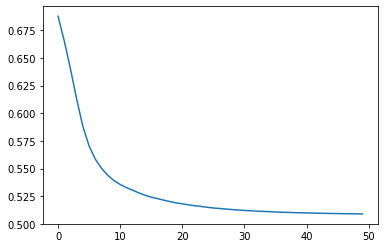

In [23]:
losses = model_detect.train(input_data, output_data, 50)
plt.plot(losses)

In [24]:
is_pos = output_data == 1.

num_true_pos = np.sum(model_detect.predict(input_data)[is_pos])
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(1 - model_detect.predict(input_data)[is_neg])
total_neg = np.sum(is_neg)

print(f'Train: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Train: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Train: True Pos: 321, Total Pos: 524
Train: True Neg: 18437, Total Neg: 22441


## Part 3: Normal Value Prediction Algorithm

In [25]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [26]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (22441, 30)
Output Data: datatype: float64, shape: (22441, 1)


In [27]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[0.47, 0.59, 0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21,
        0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.22, 0.03],
       [0.59, 0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  ,
        0.1 , 0.  , 0.  , 0.  , 0.  , 0.22, 0.03, 0.21],
       [0.42, 0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 ,
        0.  , 0.  , 0.  , 0.  , 0.22, 0.03, 0.21, 0.03],
       [0.31, 0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 , 0.  ,
        0.  , 0.  , 0.  , 0.22, 0.03, 0.21, 0.03, 0.  ],
       [0.17, 0.44, 0.41, 0.04, 0.12, 0.74, 0.01, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.1 , 0.  , 0.  ,
        0.  , 

Epoch 1/20
702/702 [==============================] - 0s 680us/step - loss: 0.0215
Epoch 2/20
702/702 [==============================] - 1s 715us/step - loss: 0.0206
Epoch 3/20
702/702 [==============================] - 0s 664us/step - loss: 0.0204
Epoch 4/20
702/702 [==============================] - 1s 730us/step - loss: 0.0203
Epoch 5/20
702/702 [==============================] - 0s 661us/step - loss: 0.0203
Epoch 6/20
702/702 [==============================] - 0s 683us/step - loss: 0.0203
Epoch 7/20
702/702 [==============================] - 0s 680us/step - loss: 0.0203
Epoch 8/20
702/702 [==============================] - 1s 909us/step - loss: 0.0203
Epoch 9/20
702/702 [==============================] - 0s 678us/step - loss: 0.0203
Epoch 10/20
702/702 [==============================] - 1s 715us/step - loss: 0.0203
Epoch 11/20
702/702 [==============================] - 1s 953us/step - loss: 0.0203
Epoch 12/20
702/702 [==============================] - 1s 970us/step - loss: 0.0203
E

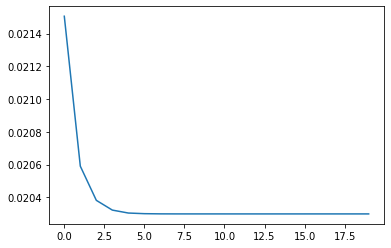

In [28]:
history = model_normal.fit(input_data, output_data, epochs=20)
plt.plot(history.history['loss'])

## Compute Test Loss

In [29]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (2472, 30)
Output Test Data: datatype: float64, shape: (2472, 1)

Test Loss: 0.2803703248500824


# Combining Algorithms

## Forecasting Training Data

In [46]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (22965, 30)
Output Test Data: datatype: float64, shape: (22965, 1)



In [47]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

In [48]:
print(pred_extreme.shape, output_data.shape)

(22965,) (22965,)


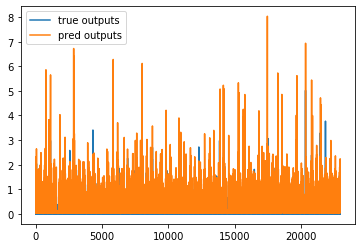

In [49]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()

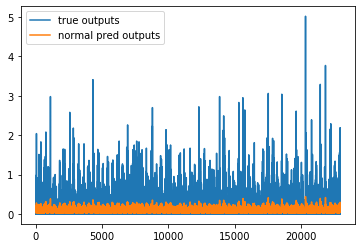

In [50]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

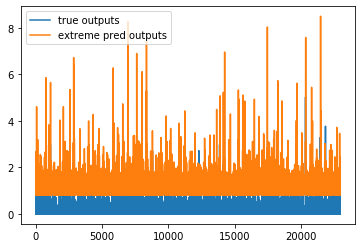

In [51]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

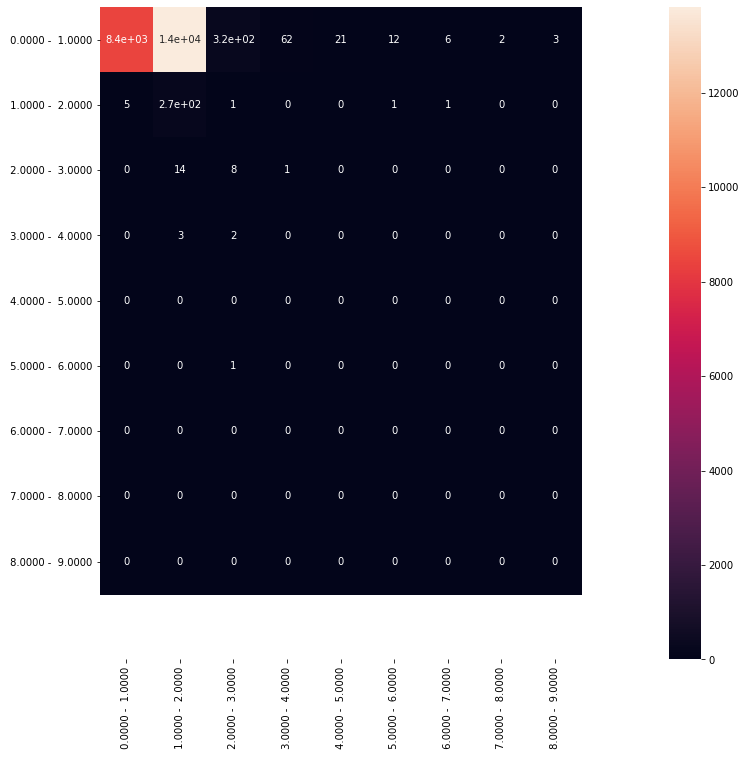

In [52]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 1., 4)

## Forecasting Test Data

In [37]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (2556, 30)
Output Test Data: datatype: float64, shape: (2556, 1)



In [38]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

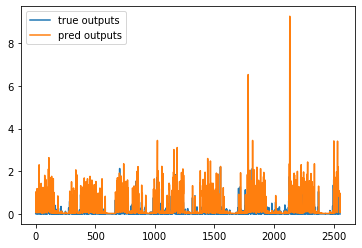

In [39]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_outputs, label='pred outputs')
plt.legend()
plt.show()

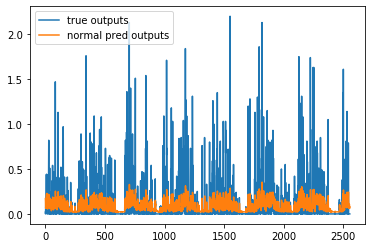

In [40]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

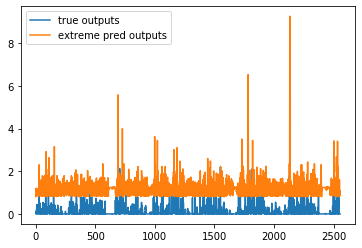

In [41]:
plt.plot(output_data, label='true outputs')
plt.plot(pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

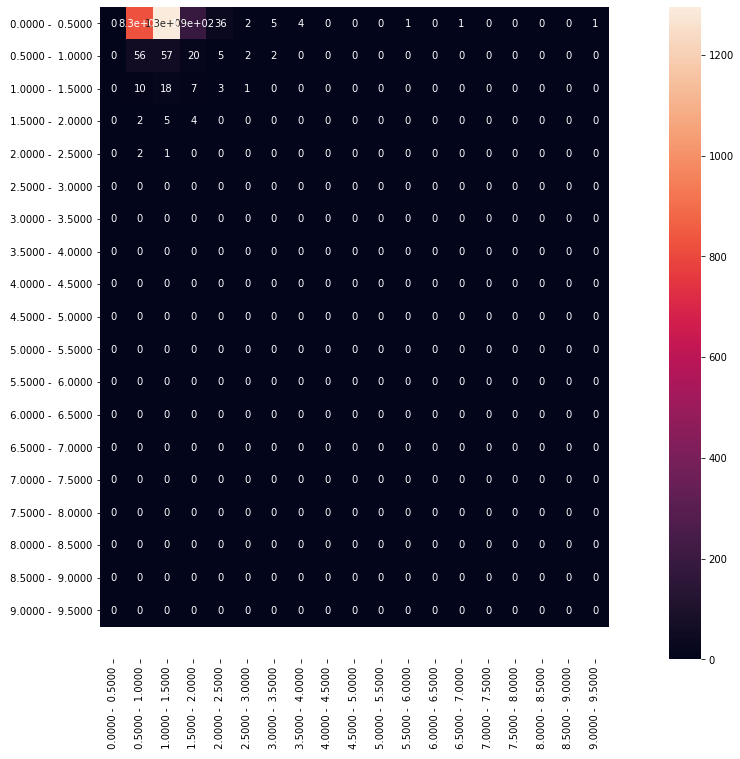

In [45]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 0.5, 4)

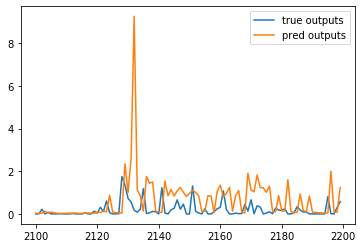

In [43]:
start_idx = 2100
end_idx = 2200

rng = range(start_idx, end_idx)
plt.plot(rng, output_data[start_idx: end_idx], label='true outputs')
plt.plot(rng, pred_outputs[start_idx: end_idx], label='pred outputs')
plt.legend()
plt.show()

In [44]:
    def plotConfusionMatrix(yTrue, yPred, width, precision=2):
        """

        :param yTrue:
        :param yPred:
        :param width:
        :param precision:
        :return:
        """

        assert yTrue.shape == yPred.shape and len(yTrue.shape) == 1

        minValue = min(yTrue.min(), yPred.min())
        maxValue = max(yTrue.max(), yPred.max())

        values = np.arange(minValue, maxValue + width, width)
        numValues = values.shape[0]
        confusionMatrix = np.zeros((numValues - 1, numValues - 1))

        n = yTrue.shape[0]
        for i in range(n):
            trueIdx = int(yTrue[i] / width)
            predIdx = int(yPred[i] / width)

            confusionMatrix[trueIdx, predIdx] += 1

        plotLabel = [f'{values[i]: .{precision}f} - {values[i + 1]: .{precision}f}' for i in range(numValues - 1)]

        confusionMatrixDf = pd.DataFrame(
            confusionMatrix,
            index=plotLabel,
            columns=plotLabel
        )

        plt.figure(figsize=(12, 12))
        ax = sns.heatmap(confusionMatrixDf, annot=True)
        ax.set_ylim(numValues, 0)
        ax.set_xlim(0, numValues)

        plt.show()